# 07.03 - Modeling - Prophet Model

## Imports & setup

In [1]:
import pathlib
import warnings
from datetime import datetime
import sys
import pickle
import joblib
import gc

import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates


# Imports
sys.path.append("..")
from src.utils.utils import (AnnualTimeSeriesSplit,
                             RollingAnnualTimeSeriesSplit,
                             bound_precision,
                             run_cross_val,
                             run_data_split_cross_val,
                             save_run_results)
from src.features.features import CyclicalToCycle
from src.models.models import SK_SARIMAX, SK_Prophet, SetTempAsPower
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         print_residual_stats,
                                         resids_vs_preds_plot)
#b # Packages
from sklearn.pipeline import Pipeline
from skoot.feature_selection import FeatureFilter
from skoot.preprocessing import SelectiveRobustScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from fbprophet import Prophet

# Display
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
figsize=(15,7)
warnings.filterwarnings(action='ignore')
%matplotlib inline

# Data
PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'
MODELS_DIR = PROJECT_DIR / 'data' / 'models'
RESULTS_PATH = PROJECT_DIR / 'data' /'results' / 'results.csv'

## Load Daily Data & Inspect

In [2]:
df = pd.read_csv(CLEAN_DATA_DIR / 'clean-features.csv', parse_dates=True, index_col=0)

In [3]:
X = df.copy(deep=True)
X = X.loc['1994': '2008']
y = X.pop('daily_peak')
X.head()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type
1994-05-24,8.998045,19.818202,19.655075,15.0,9.0,19.6,13.4,6.0,21.0,24.975000,1.0,21.0,2
1994-05-25,11.406291,20.665711,17.205396,18.0,10.4,18.2,14.0,6.0,21.0,9.358333,2.0,21.0,0
1994-05-26,2.563201,15.259916,17.722172,2.0,3.9,13.0,12.3,6.0,21.0,9.650000,3.0,21.0,0
1994-05-27,-0.012865,12.970553,6.567827,17.0,2.0,14.8,2.3,6.0,21.0,34.500000,4.0,21.0,0
1994-05-30,13.632519,30.133976,18.724332,14.0,13.1,27.2,13.6,6.0,21.0,22.270833,0.0,22.0,0


In [4]:
y.tail()

2008-09-29    18338.0
2008-09-30    17977.0
2008-10-01    18168.0
2008-10-02    18256.0
2008-10-03    17495.0
Name: daily_peak, dtype: float64

## Prophet Model 

In [5]:
n_splits=10

regressors = {col: () for col in X.columns}

prophet_model = SK_Prophet(regressors=regressors,
                           pred_periods=96)
                           
ratscv = RollingAnnualTimeSeriesSplit(n_splits=n_splits, goback_years=5)

steps = [('prophet', prophet_model)]
pipeline = Pipeline(steps)
d = run_cross_val(X, y, ratscv, pipeline, scoring=['mae', 'bound_precision'])
d

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


1999
2000
2001
2002
2003
2004
2005
2006
2007
2008


{'train': {'mae': [411.1441913926,
   443.6786425039012,
   460.24933161669566,
   503.32079152011204,
   546.0541464331849,
   578.6238690413234,
   542.3736279380049,
   561.5573041617954,
   459.75375753067004,
   538.57399283594],
  'bound_precision': [0.6, 0.8, 0.6, 0.8, 0.4, 0.2, 0.4, 0.4, 0.4, 0.2]},
 'test': {'mae': [651.4650567819293,
   653.6632936404584,
   777.4737580250126,
   709.8717669317002,
   890.5027246665408,
   572.1815548078938,
   1066.5941971982377,
   996.5182774493791,
   747.6867905615455,
   611.6205619680364],
  'bound_precision': [0.8, 0.8, 0.8, 0.4, 0.6, 0.8, 0.4, 1.0, 0.6, 0.6]}}

In [6]:
# Take a look at the results on the validation data
print(np.mean(d['test']['mae']))
print(np.mean(d['test']['bound_precision']))

767.7577982030734
0.6799999999999999


Maybe this can be improved by tuning the regressors

In [7]:
help(Prophet.add_regressor)

Help on function add_regressor in module fbprophet.forecaster:

add_regressor(self, name, prior_scale=None, standardize='auto', mode=None)
    Add an additional regressor to be used for fitting and predicting.
    
    The dataframe passed to `fit` and `predict` will have a column with the
    specified name to be used as a regressor. When standardize='auto', the
    regressor will be standardized unless it is binary. The regression
    coefficient is given a prior with the specified scale parameter.
    Decreasing the prior scale will add additional regularization. If no
    prior scale is provided, self.holidays_prior_scale will be used.
    Mode can be specified as either 'additive' or 'multiplicative'. If not
    specified, self.seasonality_mode will be used. 'additive' means the
    effect of the regressor will be added to the trend, 'multiplicative'
    means it will multiply the trend.
    
    Parameters
    ----------
    name: string name of the regressor.
    prior_scale: op

## Add More Regularization, Use Robust Scaling, Covert Cyclic features to Sin & Cosine Features, Remove Model Seasonality

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin
from fbprophet import Prophet

class SK_Prophet_1(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, regressors={}, pred_periods=96):
        self.regressors=regressors
       
        
    def prep_X(self, X):
        # Prophet requires a DataFrame with a column of dates labeled 'ds'
        if 'ds' not in X.columns:
            X = X.assign(ds = X.index)
            X.reset_index(drop=True, inplace=True)
        return X
    
    def prep_y(self, y):
        # prohet requires the target to be labeled as y
        if y.name is not 'y':
            y.name = 'y'
        return y
        
    def fit(self, X, y):
        self.X_fit = X.copy(deep=True)
        self.y_fit = y.copy(deep=True)
        
        # Setup the model with No seasonality
        self.model=Prophet(daily_seasonality=False)

        # If regressors is not empty
        if (self.regressors.keys()):
            for regressor, params in self.regressors.items():
                if params:
                    self.model.add_regressor(regressor, prior_scale=params[0], standardize=params[1], mode=params[2])
                else:
                    self.model.add_regressor(regressor)
        
        # Setup the data
        X = self.prep_X(X)
        y = self.prep_y(y)       
        df = X.merge(right=y, left_on='ds', right_on=y.index)
        
        self.model.fit(df)
        return self.model
        
    def predict(self, X):
        self.X_pred = X.copy(deep=True)
        X_ = self.prep_X(self.X_pred)
        forecast_object = self.model.predict(X_)
        # When we return the prediction, we are looking to return a datetime indexed series
        # Therefore, we need to reverse what was done in prep_X prior to returning
        preds = forecast_object.copy()
        preds.set_index('ds', drop=True, inplace=True)
        preds = preds['yhat']
        preds.index.names=['date']
        return preds
    
    def get_pred_values(self):
        # All Data is only available after fit and predict
        # Build a return DataFrame that looks similar to the prophet output
        # date index y | yhat| yhat_lower | yhat_upper | is_forecast
        full_X = pd.concat([self.prep_X(self.X_fit),
                            self.prep_X(self.X_pred)],
                            axis=0).reset_index(drop=True)
        forecast_obj = self.model.predict(full_X)
        forecast_obj['is_forecast'] = 0
        forecast_obj.set_index('ds',drop=True, inplace=True)
        del forecast_obj.index.name
        forecast_obj.loc[self.y_fit.index, 'y'] = self.y_fit.values
        forecast_obj.loc[self.X_pred.index, 'is_forecast'] = 1
        
        return forecast_obj

In [9]:
X = df.copy(deep=True)
X = X.loc['1994': '2008']
y = X.pop('daily_peak')

n_splits=10

cyclical_cols = ['hmdxx_max_hour',
                 'sun_rise',
                 'sun_set',
                 'day_of_week',
                 'week_of_year']
                 
factor = 0.05
seas_factor = 0.05
mode = 'multiplicative'
regressors = {'hmdxx_min': (factor, False, mode),
              'hmdxx_max': (factor, False, mode),
              'hmdxx_median-1': (factor, False, mode),
              'sin_hmdxx_max_hour': (seas_factor, False, mode),
              'cos_hmdxx_max_hour': (seas_factor, False, mode),
              'temp_min': (factor, False, mode),
              'temp_max': (factor, 'auto', mode),
              'dew_point_temp_max': (factor, False, mode),
              'sin_sun_rise': (factor, False, mode),
              'cos_sun_rise': (factor, False, mode),
              'sin_sun_set': (factor, False, mode),
              'cos_sun_set': (factor, False, mode),
              'sin_day_of_week': (factor, False, mode),
              'cos_day_of_week': (factor, False, mode),
              'sin_week_of_year': (factor, False, mode),
              'cos_week_of_year': (factor, False, mode),
              'visibility_mean': (factor, False, mode),
              'day_type': (factor, False, mode)}

robust_scaler_cols = ['hmdxx_min', 'hmdxx_max', 'hmdxx_median-1', 'temp_min', 'temp_max',
                      'dew_point_temp_max', 'visibility_mean']

prophet_model = SK_Prophet_1(regressors=regressors,
                           pred_periods=96)
                           
ratscv = RollingAnnualTimeSeriesSplit(n_splits=n_splits, goback_years=5)

steps = [('cyclical0', CyclicalToCycle('hmdxx_max_hour', 24)),
         ('cyclical1', CyclicalToCycle('sun_rise', 24)),
         ('cyclical2', CyclicalToCycle('sun_set', 24)),
         ('cyclical3', CyclicalToCycle('day_of_week', 5)),
         ('cyclical4', CyclicalToCycle('week_of_year', 20)),
         ('robust_scaler', SelectiveRobustScaler(cols=robust_scaler_cols, trans_col_name=robust_scaler_cols)),
         ('prophet', prophet_model)]
pipeline = Pipeline(steps)
d = run_cross_val(X, y, ratscv, pipeline, scoring=['mae', 'bound_precision'])
print(d)
print(np.mean(d['test']['mae']))
print(np.mean(d['test']['bound_precision']))

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
{'train': {'mae': [415.082578975953, 468.168935254889, 472.8762369714165, 510.9255187521164, 549.8566942558992, 578.9240430232802, 541.2251285138556, 562.0665954627076, 545.3319360704007, 550.950613026112], 'bound_precision': [0.4, 0.8, 0.8, 0.8, 0.4, 0.4, 0.2, 0.2, 0.2, 0.2]}, 'test': {'mae': [720.2185010076956, 538.3933161650724, 730.2755297430737, 712.523996800195, 938.6191160557559, 605.5866151024951, 982.0403876503733, 1038.8649887417987, 660.9264171077666, 606.0428289912938], 'bound_precision': [0.8, 0.8, 1.0, 0.4, 0.6, 0.8, 0.2, 1.0, 0.8, 0.6]}}
753.349169736552
0.7


### Review the last model run in the Cross Validation

In [10]:
pred_vals = prophet_model.get_pred_values()
val_year = pred_vals.index.year.unique()[-1]
pred_vals.loc[str(val_year), 'y'] = y.loc[str(val_year)].values

pred_vals['resid'] = pred_vals['y'].subtract(pred_vals['yhat'])
pred_vals

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cos_day_of_week,cos_day_of_week_lower,cos_day_of_week_upper,cos_hmdxx_max_hour,cos_hmdxx_max_hour_lower,cos_hmdxx_max_hour_upper,cos_sun_rise,cos_sun_rise_lower,cos_sun_rise_upper,cos_sun_set,cos_sun_set_lower,cos_sun_set_upper,cos_week_of_year,cos_week_of_year_lower,cos_week_of_year_upper,day_type,day_type_lower,day_type_upper,dew_point_temp_max,dew_point_temp_max_lower,dew_point_temp_max_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,hmdxx_max,hmdxx_max_lower,hmdxx_max_upper,hmdxx_median-1,hmdxx_median-1_lower,hmdxx_median-1_upper,hmdxx_min,hmdxx_min_lower,hmdxx_min_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,sin_day_of_week,sin_day_of_week_lower,sin_day_of_week_upper,sin_hmdxx_max_hour,sin_hmdxx_max_hour_lower,sin_hmdxx_max_hour_upper,sin_sun_rise,sin_sun_rise_lower,sin_sun_rise_upper,sin_sun_set,sin_sun_set_lower,sin_sun_set_upper,sin_week_of_year,sin_week_of_year_lower,sin_week_of_year_upper,temp_max,temp_max_lower,temp_max_upper,temp_min,temp_min_lower,temp_min_upper,visibility_mean,visibility_mean_lower,visibility_mean_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat,is_forecast,y,resid
2003-05-20,19203.268252,16527.600077,18325.207751,19203.268252,19203.268252,1437.715488,1437.715488,1437.715488,0.005340,0.005340,0.005340,-0.000738,-0.000738,-0.000738,1.732604e-18,1.732604e-18,1.732604e-18,-0.008772,-0.008772,-0.008772,-0.017772,-0.017772,-0.017772,-0.000418,-0.000418,-0.000418,0.014800,0.014800,0.014800,-0.166216,-0.166216,-0.166216,-0.099861,-0.099861,-0.099861,-0.018195,-0.018195,-0.018195,-0.044286,-0.044286,-0.044286,-0.166216,-0.166216,-0.166216,-0.004907,-0.004907,-0.004907,-5.031835e-03,-5.031835e-03,-5.031835e-03,0.002100,0.002100,0.002100,0.013140,0.013140,0.013140,2.538831e-02,2.538831e-02,2.538831e-02,-0.030029,-0.030029,-0.030029,0.003142,0.003142,0.003142,-0.000116,-0.000116,-0.000116,313.856197,313.856197,313.856197,1123.859291,1123.859291,1123.859291,17449.091169,0,18599.0,1149.908831
2003-05-21,19203.841312,16183.849452,18049.444465,19203.841312,19203.841312,1599.255960,1599.255960,1599.255960,-0.013981,-0.013981,-0.013981,-0.000738,-0.000738,-0.000738,1.732604e-18,1.732604e-18,1.732604e-18,-0.008772,-0.008772,-0.008772,-0.017772,-0.017772,-0.017772,0.000000,0.000000,0.000000,0.080497,0.080497,0.080497,-0.193649,-0.193649,-0.193649,-0.144756,-0.144756,-0.144756,-0.028505,-0.028505,-0.028505,-0.065178,-0.065178,-0.065178,-0.193649,-0.193649,-0.193649,-0.003033,-0.003033,-0.003033,-5.031835e-03,-5.031835e-03,-5.031835e-03,0.002100,0.002100,0.002100,0.013140,0.013140,0.013140,2.538831e-02,2.538831e-02,2.538831e-02,-0.031745,-0.031745,-0.031745,0.004712,0.004712,0.004712,0.000024,0.000024,0.000024,597.638031,597.638031,597.638031,1001.617929,1001.617929,1001.617929,17084.284661,0,17622.0,537.715339
2003-05-22,19204.414371,16083.397991,17956.631653,19204.414371,19204.414371,1304.606628,1304.606628,1304.606628,-0.013981,-0.013981,-0.013981,-0.002469,-0.002469,-0.002469,1.732604e-18,1.732604e-18,1.732604e-18,-0.008772,-0.008772,-0.008772,-0.017772,-0.017772,-0.017772,0.000000,0.000000,0.000000,0.108653,0.108653,0.108653,-0.183729,-0.183729,-0.183729,-0.153227,-0.153227,-0.153227,-0.042193,-0.042193,-0.042193,-0.066689,-0.066689,-0.066689,-0.183729,-0.183729,-0.183729,0.003033,0.003033,0.003033,-2.604669e-03,-2.604669e-03,-2.604669e-03,0.002100,0.002100,0.002100,0.013140,0.013140,0.013140,2.538831e-02,2.538831e-02,2.538831e-02,-0.033118,-0.033118,-0.033118,0.004759,0.004759,0.004759,0.000024,0.000024,0.000024,428.959485,428.959485,428.959485,875.647144,875.647144,875.647144,16980.605850,0,17662.0,681.394150
2003-05-23,19204.987431,15737.207270,17606.072613,19204.987431,19204.987431,489.079535,489.079535,489.079535,0.005340,0.005340,0.005340,-0.002851,-0.002851,-0.002851,1.

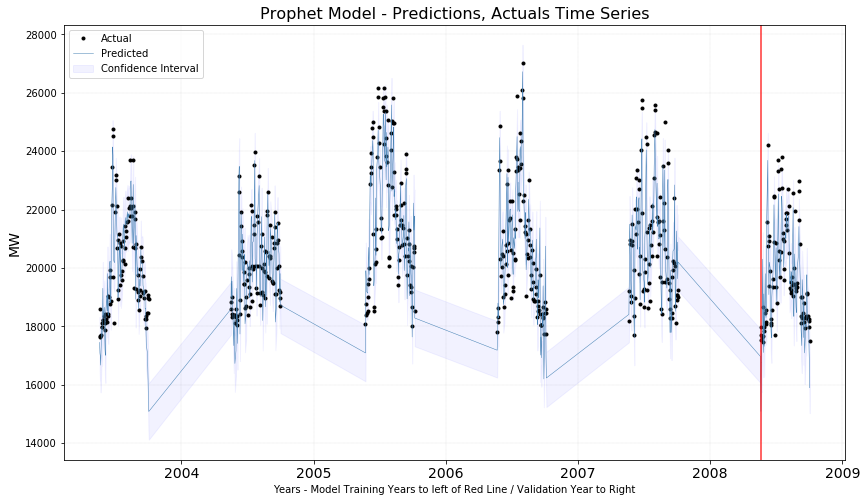

In [11]:
fig, ax = plot_prediction(pred_vals, goback_years=20)
ax.set_title('Prophet Model - Predictions, Actuals Time Series', fontsize=16)
ax.set_ylabel('MW', fontsize=14)
ax.set_xlabel('Years - Model Training Years to left of Red Line / Validation Year to Right')
plt.xticks(fontsize=14)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'prophet-prediction-plot-train5.PNG', bbox_inches='tight')
plt.show();

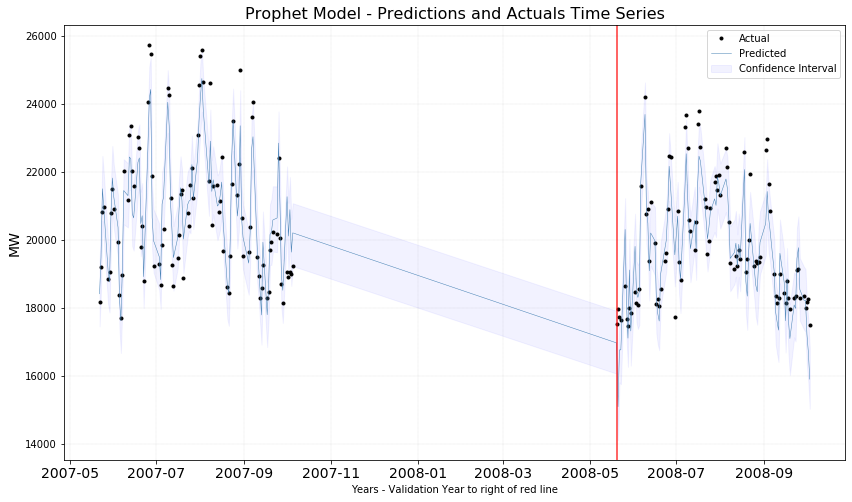

In [12]:
fig, ax = plot_prediction(pred_vals, goback_years=2)
ax.set_title('Prophet Model - Predictions and Actuals Time Series', fontsize=16)
ax.set_ylabel('MW', fontsize=14)
ax.set_xlabel('Years - Validation Year to right of red line')
plt.xticks(fontsize=14)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'prophet-prediction-plot-train1.PNG', bbox_inches='tight')
plt.show();

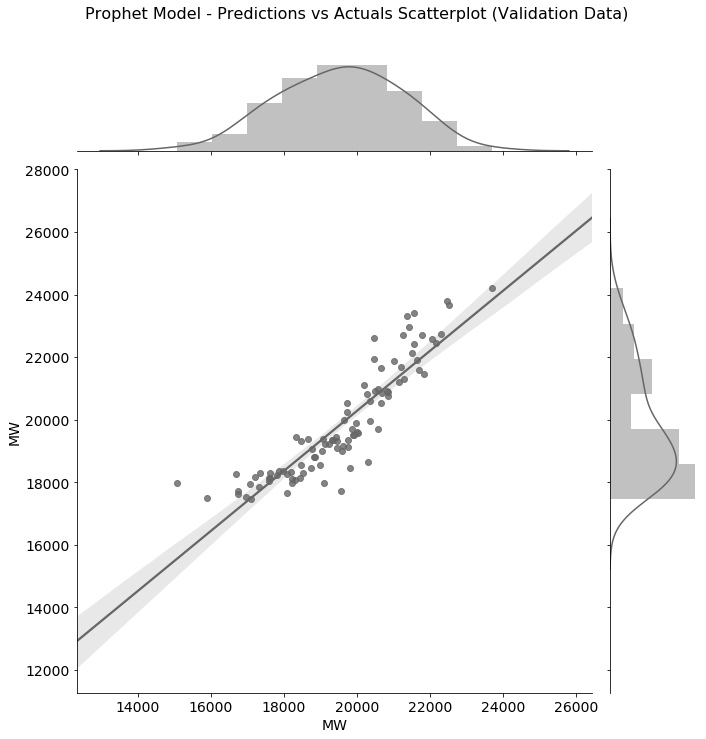

In [13]:
fig, ax = plot_joint_plot(pred_vals, goback_years=1)
plt.suptitle('Prophet Model - Predictions vs Actuals Scatterplot (Validation Data)', fontsize=16, y=1.05)
ax.set_ylabel('MW', fontsize=14)
ax.set_xlabel('MW', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'prophet-prediction-actual-scatter-plot.PNG', bbox_inches='tight')
plt.show();

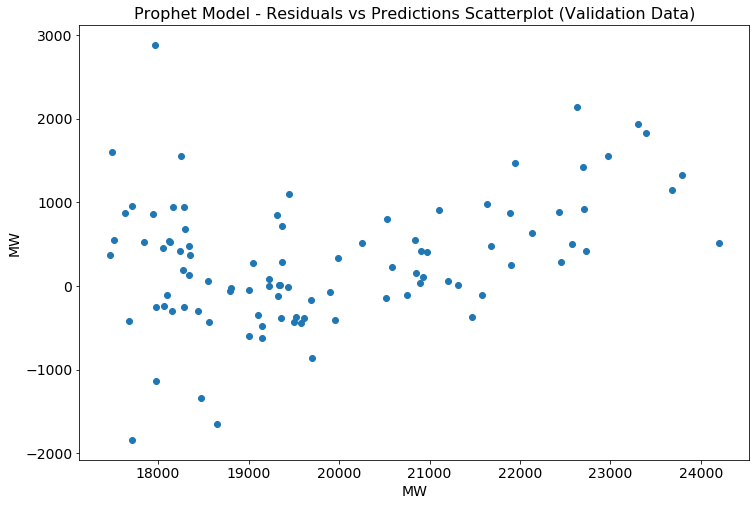

In [14]:
fig, ax = resids_vs_preds_plot(pred_vals)
ax.set_title('Prophet Model - Residuals vs Predictions Scatterplot (Validation Data)', fontsize=16)
ax.set_ylabel('MW', fontsize=14)
ax.set_xlabel('MW', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'prophet-residual-prediction-scatter-plot.PNG', bbox_inches='tight')
plt.show();

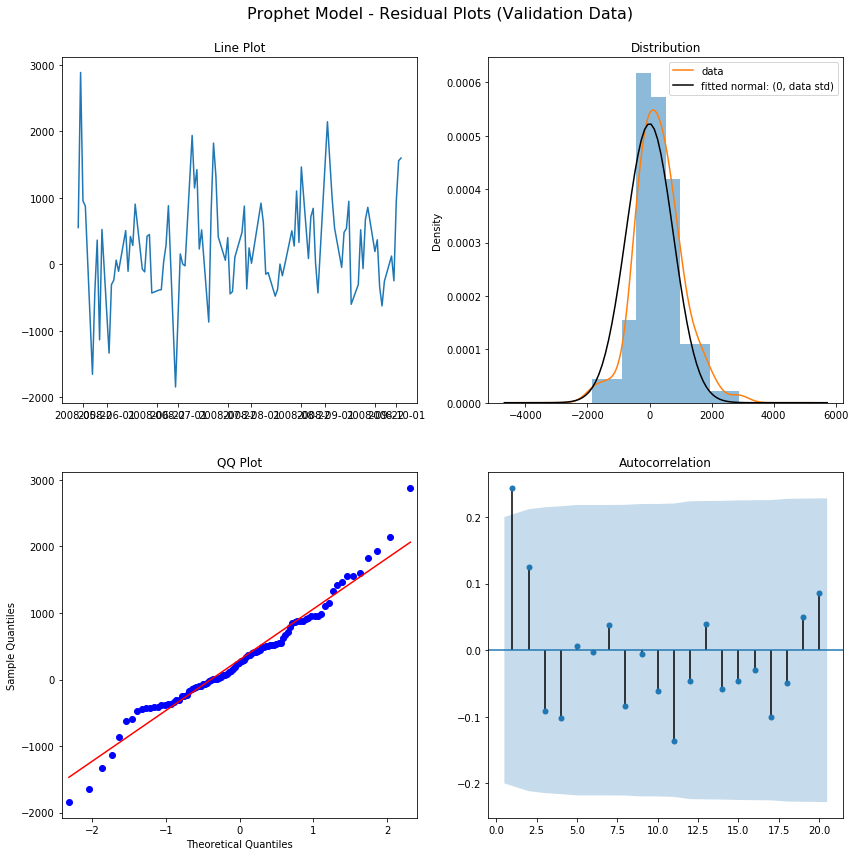

In [15]:
fig, ax = residual_plots(pred_vals)
plt.suptitle('Prophet Model - Residual Plots (Validation Data)', fontsize=16, y=0.93)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'prophet-residuals-diagnosis-plots.PNG', bbox_inches='tight')
plt.show();

In [16]:
print_residual_stats(pred_vals)

LJung Box Corr p value:		0.38132
Jarque Bera Normal p value:	0.02325


### Comments on Diagnosis Plots

The normal distribution is off at the extremes

The residuals vs predictions plot, I think, shows a pattern with increasing residuals at higher prediction values

Looks like we have not captured all the auto-correlations adequatle, because I see a significant auto-correlation at lag 1

Maybe the line plot shows decreasing variability over time?

Based on these observations, it seems like there may be some information left in the residuals that we can extract using another model

In [17]:
df = save_run_results(X, n_splits, 'Prophet', d, RESULTS_PATH)
df

Baseline                      Prophet                
              mae bound_precision          mae bound_precision
1999   785.341009             0.6   720.218501             0.8
2000   841.496643             0.8   538.393316             0.8
2001   971.010973             0.6   730.275530             1.0
2002  1120.417756             0.4   712.523997             0.4
2003  1576.417824             0.6   938.619116             0.6
2004  1447.394438             0.6   605.586615             0.8
2005  1137.307718             0.2   982.040388             0.2
2006  1502.960994             0.8  1038.864989             1.0
2007  2523.435378             0.6   660.926417             0.8
2008  2433.310031             0.8   606.042829             0.6